# データの用意

In [ ]:
import sys
import os
import torch
import torchvision.transforms as transforms

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src.my_app.core.MyDataset.OldMyDataset_speed import PreTrainDataset_old
import torch.nn as nn
import torch.nn.functional as F

In [41]:
# --- Dataset ---
transform = transforms.Compose([
    # transforms.Resizeze((128, 128)),
    transforms.ToTensor()
])
test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']

train_dataset = dataset = PreTrainDataset_old(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # precompute_gt=True,
    precompute_gt=False,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)

test_dataset = PreTrainDataset_old(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=True,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # precompute_gt=True,
    precompute_gt=False,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)

json データを読み込みました。
json データを読み込みました。


# 損失関数の定義


In [42]:
class FocalLoss(nn.Module):
    """
    Wraps focal loss around existing loss_fcn(), i.e. criteria = FocalLoss(nn.BCEWithLogitsLoss(), gamma=1.5).

    Implements the Focal Loss function for addressing class imbalance by down-weighting easy examples and focusing
    on hard negatives during training.
    
    Attributes:
        gamma (float): The focusing parameter that controls how much the loss focuses on hard-to-classify examples.
        alpha (torch.Tensor): The balancing factor used to address class imbalance.
    """

    def __init__(self, gamma: float = 1.5, alpha: float = 0.25):
        """Initialize FocalLoss class with focusing and balancing parameters."""
        super().__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha)

    def forward(self, pred: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
        """Calculate focal loss with modulating factors for class imbalance."""
        loss = F.binary_cross_entropy_with_logits(pred, label, reduction="none")
        # p_t = torch.exp(-loss)
        # loss *= self.alpha * (1.000001 - p_t) ** self.gamma  # non-zero power for gradient stability

        # TF implementation https://github.com/tensorflow/addons/blob/v0.7.1/tensorflow_addons/losses/focal_loss.py
        pred_prob = pred.sigmoid()  # prob from logits
        p_t = label * pred_prob + (1 - label) * (1 - pred_prob)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss *= modulating_factor
        if (self.alpha > 0).any():
            self.alpha = self.alpha.to(device=pred.device, dtype=pred.dtype)
            alpha_factor = label * self.alpha + (1 - label) * (1 - self.alpha)
            loss *= alpha_factor
        return loss.mean(1).sum()

In [43]:
pred = torch.randn(1,4, 300, 300)
label = torch.randint(0, 2, (1, 4, 300, 300)).float()
fl = FocalLoss(gamma=1.5, alpha=0.25)
loss = fl(pred, label)
print(f"Focal Loss: {loss.item()}")

Focal Loss: 18680.4375


In [44]:
print(pred.shape, label.shape, fl, loss)

torch.Size([1, 4, 300, 300]) torch.Size([1, 4, 300, 300]) FocalLoss() tensor(18680.4375)


In [45]:
pre = None
for data in train_dataset:
    if pre is not None:
        # print(data[1].shape, pre[1].shape)
        if data[1].shape == pre[1].shape:
            d1 = data[1].unsqueeze(0)
            d2 = pre[1].unsqueeze(0)
            print(d1.shape, d2.shape)
            print(fl(d1.detach(), d2.detach()))
        else:
            print('*', end='')
    pre = data

****torch.Size([1, 4, 478, 300]) torch.Size([1, 4, 478, 300])
tensor(27170.5254)
**************torch.Size([1, 4, 485, 300]) torch.Size([1, 4, 485, 300])
tensor(27285.1797)
torch.Size([1, 4, 485, 300]) torch.Size([1, 4, 485, 300])
tensor(27198.8281)
******torch.Size([1, 4, 480, 300]) torch.Size([1, 4, 480, 300])
tensor(26907.4570)
****************************************************************************************************************************************torch.Size([1, 4, 480, 300]) torch.Size([1, 4, 480, 300])
tensor(27312.7617)
****************************************************************torch.Size([1, 4, 487, 300]) torch.Size([1, 4, 487, 300])
tensor(27583.8047)
torch.Size([1, 4, 487, 300]) torch.Size([1, 4, 487, 300])
tensor(27593.6816)
********torch.Size([1, 4, 487, 300]) torch.Size([1, 4, 487, 300])
tensor(27486.5020)
****torch.Size([1, 4, 483, 300]) torch.Size([1, 4, 483, 300])
tensor(27321.2871)
********************************torch.Size([1, 4, 471, 300]) torch.Size

KeyboardInterrupt: 

d1 shape: torch.Size([1, 4, 478, 300]), d2 shape: torch.Size([1, 4, 478, 300])
d1 range: [0.0000, 0.9922]
d2 range: [0.0000, 1.0118]
d1 has NaN: False
d2 has NaN: True
d1 has Inf: False
d2 has Inf: False


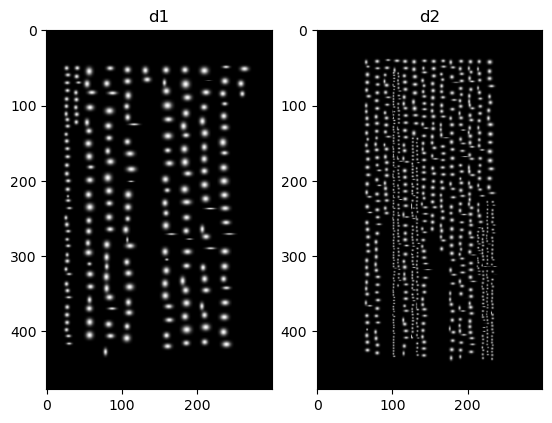

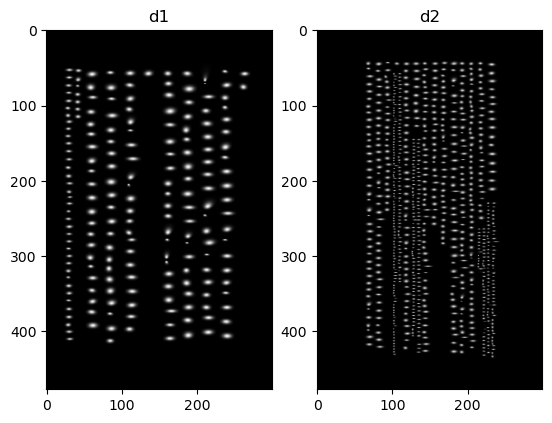

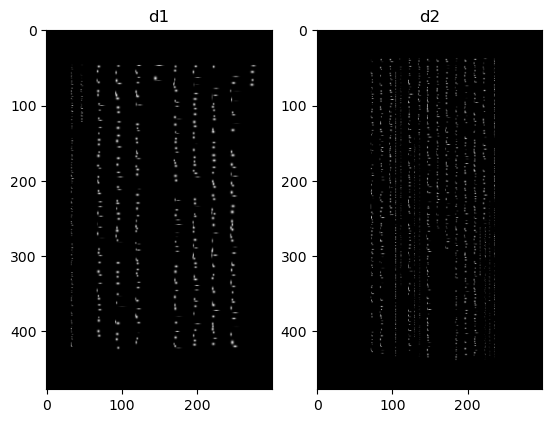

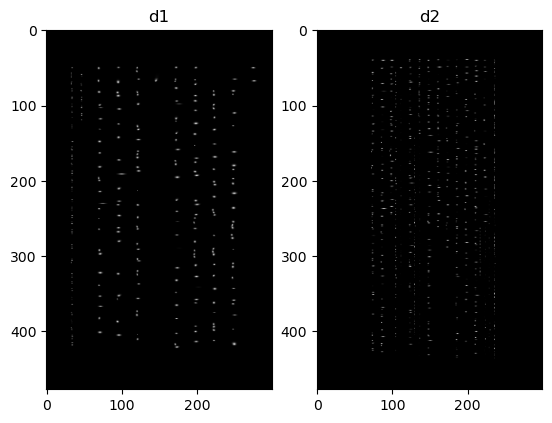

Loss result: 27170.525390625


In [46]:
from matplotlib import pyplot as plt
pre = None
for data in train_dataset:
    if pre is not None:
        # print(data[1].shape, pre[1].shape)
        if data[1].shape == pre[1].shape:
            d1 = data[1].unsqueeze(0)
            d2 = pre[1].unsqueeze(0)
            print(f"d1 shape: {d1.shape}, d2 shape: {d2.shape}")
            print(f"d1 range: [{d1.min():.4f}, {d1.max():.4f}]")
            print(f"d2 range: [{d2.min():.4f}, {d2.max():.4f}]")
            print(f"d1 has NaN: {torch.isnan(d1).any()}")
            print(f"d2 has NaN: {d2.any()}")
            print(f"d1 has Inf: {torch.isinf(d1).any()}")
            print(f"d2 has Inf: {torch.isinf(d2).any()}")
            for i in range(4):    
                plt.subplot(1, 2, 1)
                plt.imshow(d1[0, i].cpu().numpy(), cmap='gray')
                plt.title('d1')
                plt.subplot(1, 2, 2)
                plt.imshow(d2[0, i].cpu().numpy(), cmap='gray')
                plt.title('d2')            
                plt.show()
            # Focal Lossの計算前に中間値もチェック
            loss_result = fl(d1.detach(), d2.detach())
            print(f"Loss result: {loss_result}")
            break  # 最初の1つだけチェック
    pre = data

In [47]:
from ultralytics import YOLO

# YOLOv8の学習済みモデルをロード
model = YOLO('yolov8n.pt')  # 'n'はnanoモデルの意味。他にもs, m, l, xなどがあります。

# 画像を指定して推論を実行
# sourceには画像のパス、URL、動画ファイル、カメラID(0)などを指定できます。
# results = model('../../.image_data/100241706_00002_2.jpg')
# results = model('https://ultralytics.com/images/bus.jpg')

# # 結果の表示
# for r in results:
#     r.show() # 結果を画像で表示

# 結果をファイルに保存
# results = model('https://ultralytics.com/images/bus.jpg', save=True, project='my_results', name='bus_detection')

100%|██████████| 6.25M/6.25M [00:00<00:00, 7.93MB/s]


In [51]:
import torch.nn.functional as F
image = train_dataset[0][0]  # 画像データを取得
# Add batch dimension and resize to (1, 3, 640, 640)
# image_resized = F.interpolate(image.unsqueeze(0), size=(640, 640), mode='bilinear', align_corners=False)
results = model(image.unsqueeze(0))

ValueError: torch.Tensor inputs should be BCHW i.e. shape(1, 3, 640, 640) divisible by stride 32. Input shape(1, 3, 471, 300) is incompatible.